# 1. Business Understanding
In the context of the CRISP-DM framework, the task of identifying the key drivers of exceeding the $50K income threshold can be reframed as a data analysis problem as follows:

The primary objective is to conduct an assessment of the Scope and Quality of the dataset containing ~43k entries to drive subsequent dataset cleaning. This involves the identification of missing data, skewed histograms, under-represented input variables, inconsistent data, duplicates, outlier values, and imbalances in the target variable classes. 

This is followed by an Exploratory Data Analysis (EDA) to uncover trends, patterns, and relationships. This involves statistical analysis and visualizations to understand the distribution and characteristics of the input features in the dataset (e.g. age, education, race, gender).

In the data preparation phase of the CRISP-DM process, the focus is on cleaning, pre-processing, and transforming the dataset to make it suitable for analysis and modeling based on the findings from the earlier scope and quality checks. This phase is crucial as the quality of data significantly affects the outcome of the analysis.

In the modeling phase, the task progresses to predictive modeling, where the goal is to select the best classification model from several trained, tuned, and validated models based on the dataset. Models are trained and tuned using hyper-parameters to aid in the identification better models. Before training the model(s), the cleaned dataset is split into training and test datasets. Numeric columns are scaled and categorical columns are encoded to numeric values.

Once a set of validated models is identified, the best, validated model is selected for deployment, and feature importances are extracted to complement the earlier conclusions derived from the Exploratory Data Analysis (EDA).  

In [2]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics             import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection     import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.model_selection     import KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold

from sklearn.preprocessing       import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.neighbors           import KNeighborsClassifier
from sklearn.linear_model        import LogisticRegression
from sklearn.tree                import DecisionTreeClassifier
from sklearn.ensemble            import RandomForestClassifier
from sklearn.svm                 import SVC
from sklearn.neural_network      import MLPClassifier

from functools                   import partial
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers           import KerasClassifier

from sklearn.compose             import ColumnTransformer
from sklearn.impute              import SimpleImputer
from sklearn.pipeline            import Pipeline

from scipy.stats                 import sem
from imblearn.over_sampling      import RandomOverSampler, SMOTE
from imblearn.combine            import SMOTETomek
from imblearn.pipeline           import Pipeline as ImbPipeline

%matplotlib inline

# 2. Data Understanding
This part involves exploring the dataset to understand its structure, quality, and the types of information it contains. It's implemented with four steps:

1. Understanding Data Scope
2. Understanding data types.
3. Understanding data quality.
4. Completing Exploratory Data Anlysis.

## 2.1: Data Scope
Obtain a general sense of the size and content of the dataset. Determine the column that will serve as the target variable, and which columns will serve as inputs to the analysis.

In [3]:
# Import data
df = pd.read_csv("DATA/income.csv")

In [4]:
df.sample(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
36941,42,Self-emp-inc,230592,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,0
9732,39,Private,153976,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,0
37820,73,Private,26248,7th-8th,4,Married-civ-spouse,Sales,Husband,White,Male,0,0,30,United-States,1
36925,42,Private,198422,Some-college,10,Divorced,Adm-clerical,Own-child,White,Female,0,0,40,United-States,0
2899,41,Private,84817,Assoc-voc,11,Divorced,Prof-specialty,Unmarried,White,Female,3887,0,40,United-States,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   fnlwgt           43957 non-null  int64 
 3   education        43957 non-null  object
 4   educational-num  43957 non-null  int64 
 5   marital-status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital-gain     43957 non-null  int64 
 11  capital-loss     43957 non-null  int64 
 12  hours-per-week   43957 non-null  int64 
 13  native-country   43194 non-null  object
 14  income_>50K      43957 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.0+ MB


In [6]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_>50K
count,43957.000000,4.395700e+04,43957.000000,43957.000000,43957.000000,43957.000000,43957.000000
mean,38.617149,1.896730e+05,10.074118,1093.559797,88.246491,40.407694,0.239279
std,13.734401,1.058215e+05,2.575092,7570.536063,404.588410,12.400303,0.426648
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.174960e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781000e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376710e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## 2.2: Data Types and Classes
Obtain the data type of each column. Determine which columns are numerical and which are categorical. Dtermine the acceptable ranges for numerical values. Determine the number of unique values in each categorical column as well as the acceptable values for each column. Identify derived columns and/or data transformations that might be useful for the analysis.

In [7]:
################################################################################################################################
#Determine the unique values for each column
################################################################################################################################
for col in df.columns:
    print(f"# of Unique values in '{col}':", df[col].nunique())
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print()
    
#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
#Can implement single column incoding for 'default', 'housing', 'loan', and '' columns

# of Unique values in 'age': 74
Unique values in 'age':
[67 17 31 58 25 59 70 35 28 21 30 20 45 76 54 19 44 47 37 27 24 49 36 71
 62 64 53 34 42 26 43 23 56 40 63 50 29 52 33 38 66 46 32 68 41 80 73 39
 57 51 69 22 18 55 65 60 48 61 72 90 74 77 75 81 82 88 84 83 79 78 85 89
 87 86]

# of Unique values in 'workclass': 8
Unique values in 'workclass':
['Private' 'State-gov' 'Self-emp-not-inc' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' nan 'Never-worked' 'Without-pay']

# of Unique values in 'fnlwgt': 26646
Unique values in 'fnlwgt':
[366425 244602 174201 ...  68982 116562 375827]

# of Unique values in 'education': 16
Unique values in 'education':
['Doctorate' '12th' 'Bachelors' '7th-8th' 'Some-college' 'HS-grad' '9th'
 '10th' '11th' 'Masters' 'Preschool' '5th-6th' 'Prof-school' 'Assoc-voc'
 '1st-4th' 'Assoc-acdm']

# of Unique values in 'educational-num': 16
Unique values in 'educational-num':
[16  8 13  4 10  9  5  6  7 14  1  3 15 11  2 12]

# of Unique values in 'marital-status': 7
Uni

## 2.3: Data Quality
Assess the data quality. Determine if there are any duplicate entries, missing values, and inconsistencies between columns. Develop strategies for dealing with them. For example, misclassifications in one column can often be determined and corrected based on information in another column.

In [8]:
################################################################################################################################
# Check the numeric columns for specific values or ranges of values
################################################################################################################################
num_cols = df.select_dtypes(include=['int64', 'float64'])

# Initialize a DataFrame to hold the counts
count_table = pd.DataFrame(index=num_cols.columns, columns=['== -1','<  0', '==  0', '>  0', '==  1', 'NaN', 'Min', 'Max'])

# Populate the table with counts
for column in num_cols.columns:
    count_table.loc[column, '== -1'] = (num_cols[column] == -1).sum()
    count_table.loc[column,  '<  0'] = (num_cols[column] <   0).sum()
    count_table.loc[column, '==  0'] = (num_cols[column] ==  0).sum()
    count_table.loc[column,  '>  0'] = (num_cols[column] >   0).sum()
    count_table.loc[column, '==  1'] = (num_cols[column] ==  1).sum()
    count_table.loc[column, '==  ?'] = (num_cols[column] ==  1).sum()
    count_table.loc[column,   'NaN'] =  num_cols[column].isna().sum()
    count_table.loc[column,   'Min'] =  num_cols[column].min()
    count_table.loc[column,   'Max'] =  num_cols[column].max()

count_table

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# 87% of the entries do not involve capital gains or losses. Therefore, rows reflecting capital gains and losses will be excluded
# from the analysis.

,== -1,< 0,== 0,> 0,== 1,NaN,Min,Max,== ?
age,0,0,0,43957,0,0,17,90,0.0
fnlwgt,0,0,0,43957,0,0,13492,1490400,0.0
educational-num,0,0,0,43957,76,0,1,16,76.0
capital-gain,0,0,40330,3627,0,0,0,99999,0.0
capital-loss,0,0,41884,2073,0,0,0,4356,0.0
hours-per-week,0,0,0,43957,26,0,1,99,26.0
income_>50K,0,0,33439,10518,10518,0,0,1,10518.0


In [9]:
################################################################################################################################
# Check for the percentage of missing values designated as 'NaN'
################################################################################################################################
object_columns_df = df.select_dtypes(include=['object'])
nan_percent = object_columns_df.isnull().sum() / object_columns_df.shape[0] * 100
nan_percent_formatted = nan_percent.round(1).astype(str) + ' %'
print(nan_percent_formatted)

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
#There are very few missing values. Therefore, rows with missing values can simply be dropped from the dataset
#Capital-gain and Capital-loss columns are sparsely populated with non-zero values. Therefore, they are dropped from the dataset.

workclass         5.7 %
education         0.0 %
marital-status    0.0 %
occupation        5.7 %
relationship      0.0 %
race              0.0 %
gender            0.0 %
native-country    1.7 %
dtype: object


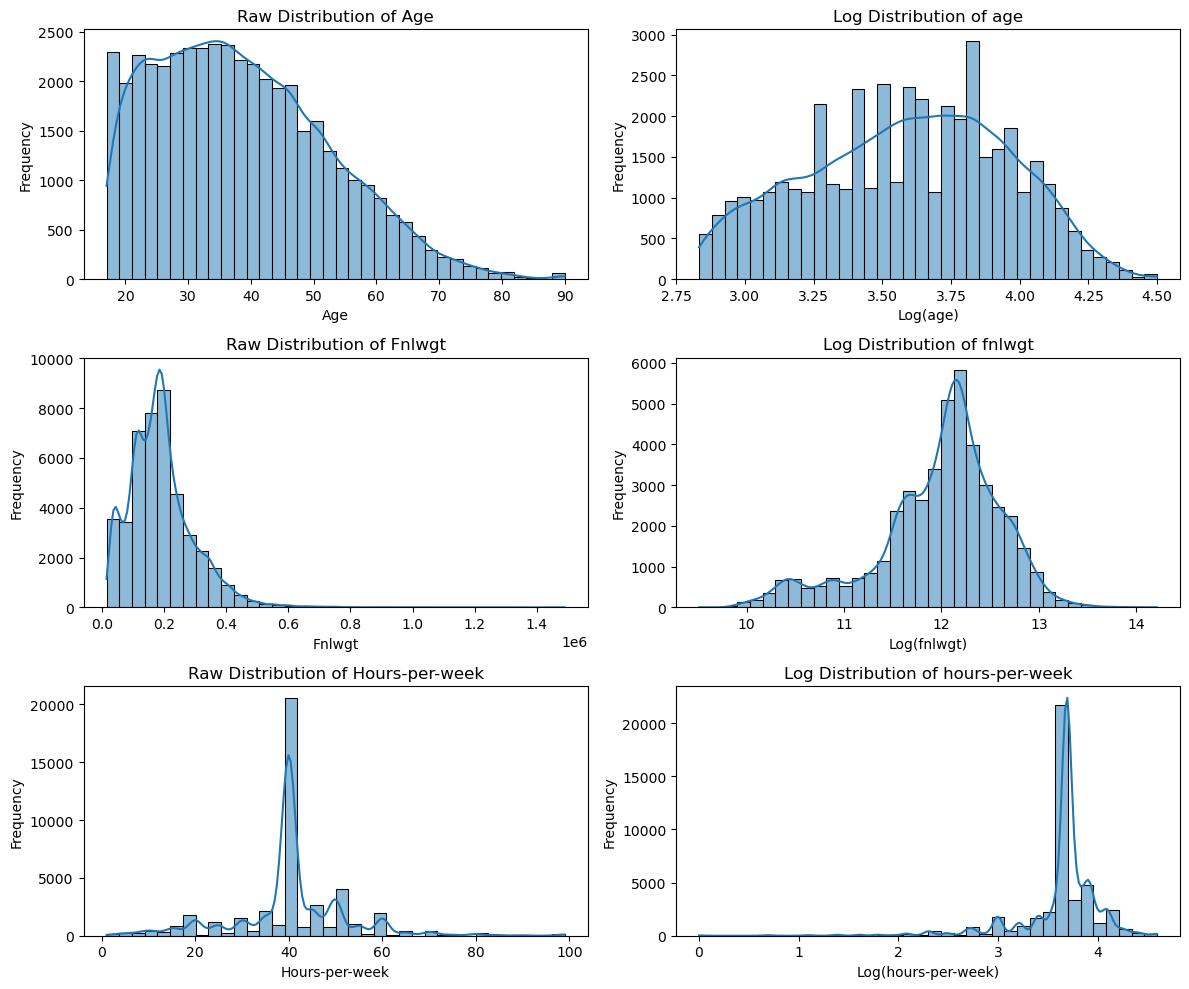

In [10]:
################################################################################################################################
# Check histograms of all Continuous Numeric Variables
################################################################################################################################

import warnings
warnings.filterwarnings("ignore")

# list of numerical features
features = ['age', 'fnlwgt', 'hours-per-week']

# Setting up the subplot environment
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(12, 10))

# Loop through the features for side-by-side plots
for i, feature in enumerate(features):

    # Raw data plot on the left
    sns.histplot(df[feature], bins=36, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Raw Distribution of {feature.capitalize()}')
    axes[i, 0].set_xlabel(feature.capitalize())
    axes[i, 0].set_ylabel('Frequency')
    
    # Log transformation and plot on the right, excluding NaN values for 'pdays'
    sns.histplot(np.log(df[feature]), bins=36, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Log Distribution of {feature}')
    axes[i, 1].set_xlabel(f'Log({feature})')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# The distributions of all the continuous numeric variables are improved by taking their log values

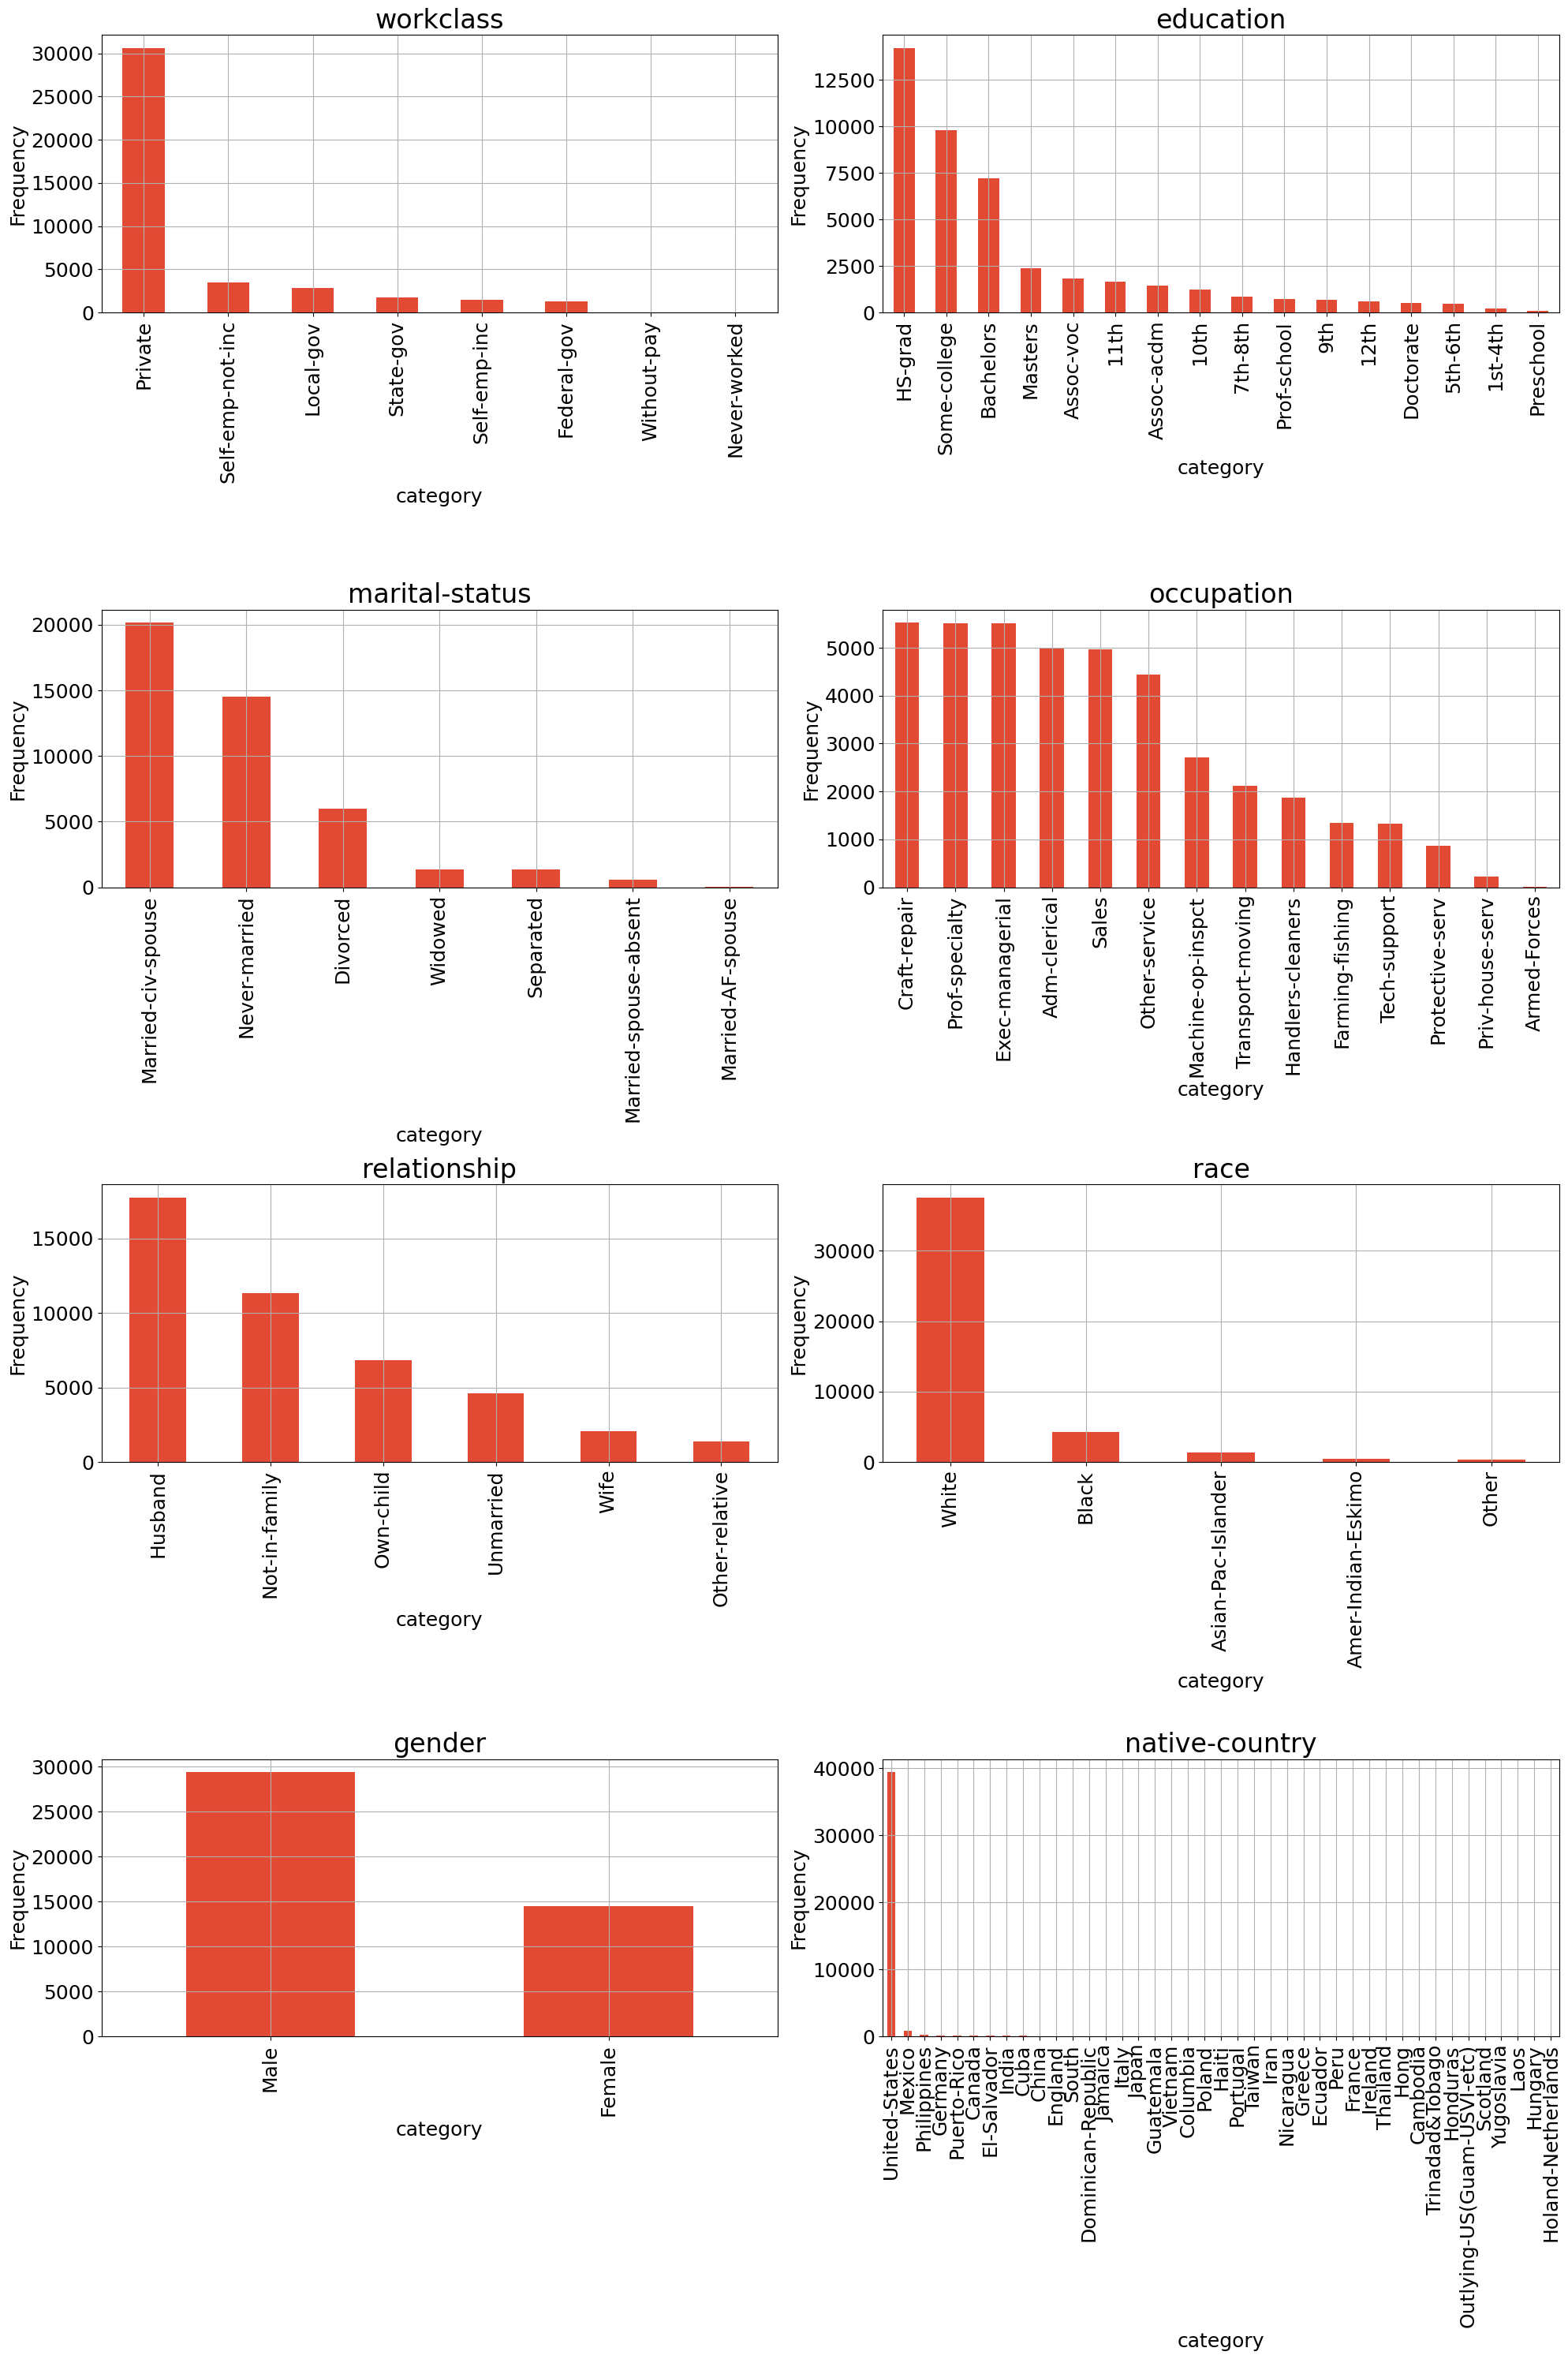

In [11]:
################################################################################################################################
# Determine raw Class Counts
################################################################################################################################

cat_var = df.select_dtypes(include=["object"]).columns

# Setting up the matplotlib figure and axes for a 5x2 subplot
fig, axs = plt.subplots(4, 2, figsize=(20, 30))  # Adjust the figure size as necessary
plt.style.use("ggplot")

# Flattening the axes array for easy iteration
axs = axs.flatten()

for i, column in enumerate(cat_var):
    if i < 10:  # Ensuring we only plot for the first 10 categorical variables
        df[column].value_counts().plot(kind="bar", ax=axs[i])
        axs[i].set_xlabel(column)
        axs[i].set_ylabel("number of customers")
        axs[i].set_title(column, fontsize=24)
    else:
        break  # Exit the loop if there are more than 10 categorical variables
    axs[i].set_xlabel("category", fontsize=18)  # Increase font size for x-axis label
    axs[i].set_ylabel('Frequency', fontsize=18)  # Increase font size for y-axis label
    axs[i].tick_params(axis='x', rotation=90, labelsize=18)  # Increase font size for x-axis tick labels
    axs[i].tick_params(axis='y', labelsize=18)  # Increase font size for y-axis tick labels
       

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# The education plot does not show a clear trend for individuals with less than a high school education. Therefore, all classes
# representing less than a high school education can be combined into a single class.

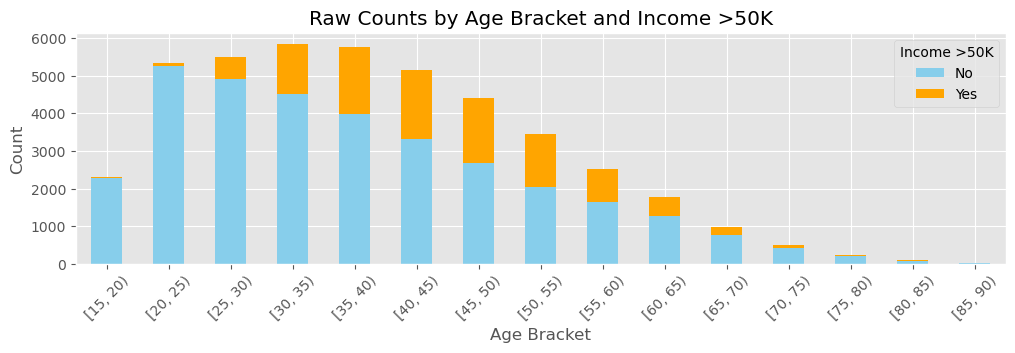

In [12]:
#################################################################################################################
# Target Variable Class Counts by binned Age
#================================================================================================================
# Assuming 'df' is your DataFrame and it contains 'age' and 'income_>50K' columns
max_age = df['age'].max()
bins = np.arange(15, max_age + 5, 5)  # Creating bins from min age to max age, every 5 years
df['age_bracket'] = pd.cut(df['age'], bins, right=False)  # Categorizing ages into bins

# Group by 'age_bracket' and 'income_>50K', then count the number of occurrences
age_bin_grouped = df.groupby(['age_bracket', 'income_>50K']).size().unstack(fill_value=0)

# Plotting directly with specified figure size
age_bin_grouped.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(12, 3))  # Specifying figure size here
plt.title("Raw Counts by Age Bracket and Income >50K")
plt.xlabel("Age Bracket")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Income >50K', labels=['No', 'Yes'])  # Customize the legend
plt.show()
#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Target Ratio (>50K : Other) increases with age up to 55 and then decreases thereafter

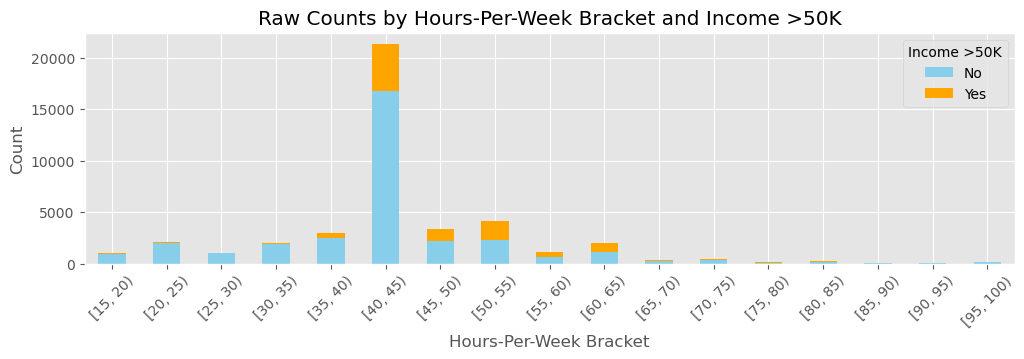

In [13]:
#################################################################################################################
# Target Variable Class Counts by Binned Hours-Per-Week
#================================================================================================================
# Assuming 'df' is your DataFrame and it contains 'age' and 'income_>50K' columns
max_age = df['hours-per-week'].max()
bins = np.arange(15, max_age + 5, 5)  # Creating bins from min age to max age, every 5 years
df['hours-per-week_bracket'] = pd.cut(df['hours-per-week'], bins, right=False)  # Categorizing ages into bins

# Group by 'age_bracket' and 'income_>50K', then count the number of occurrences
age_bin_grouped = df.groupby(['hours-per-week_bracket', 'income_>50K']).size().unstack(fill_value=0)

# Plotting directly with specified figure size
age_bin_grouped.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(12, 3))  # Specifying figure size here
plt.title("Raw Counts by Hours-Per-Week Bracket and Income >50K")
plt.xlabel("Hours-Per-Week Bracket")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Income >50K', labels=['No', 'Yes'])  # Customize the legend
plt.show()
#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Target Ratio (>50K : Other) increases with age up to 55 and then decreases thereafter

<Axes: xlabel='income_>50K', ylabel='count'>

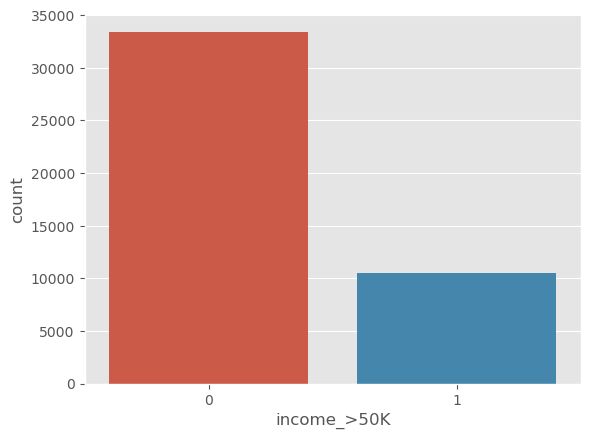

In [14]:
################################################################################################################################
# Target Class Counts
################################################################################################################################
sns.countplot(data=df,x='income_>50K')

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Target variable has only two classes: 1 and 0, where 1 => >$50K and 0 => <=$50K
# The target variable is imbalanced with approximately 3.5 times the number of 0 to 1 values. Therefore, we will want to balance
# the dataset to get a better result in our predictions.

## 2.4: Exploratory Data Analysis (EDA)
Use bar plots, to get a sense of the relationships between the columns. Develop strategies. Identify opportunities for model simplification, particularly with respect to the numerical columns, which may have interdependencies as identified by principal componenents analysis.

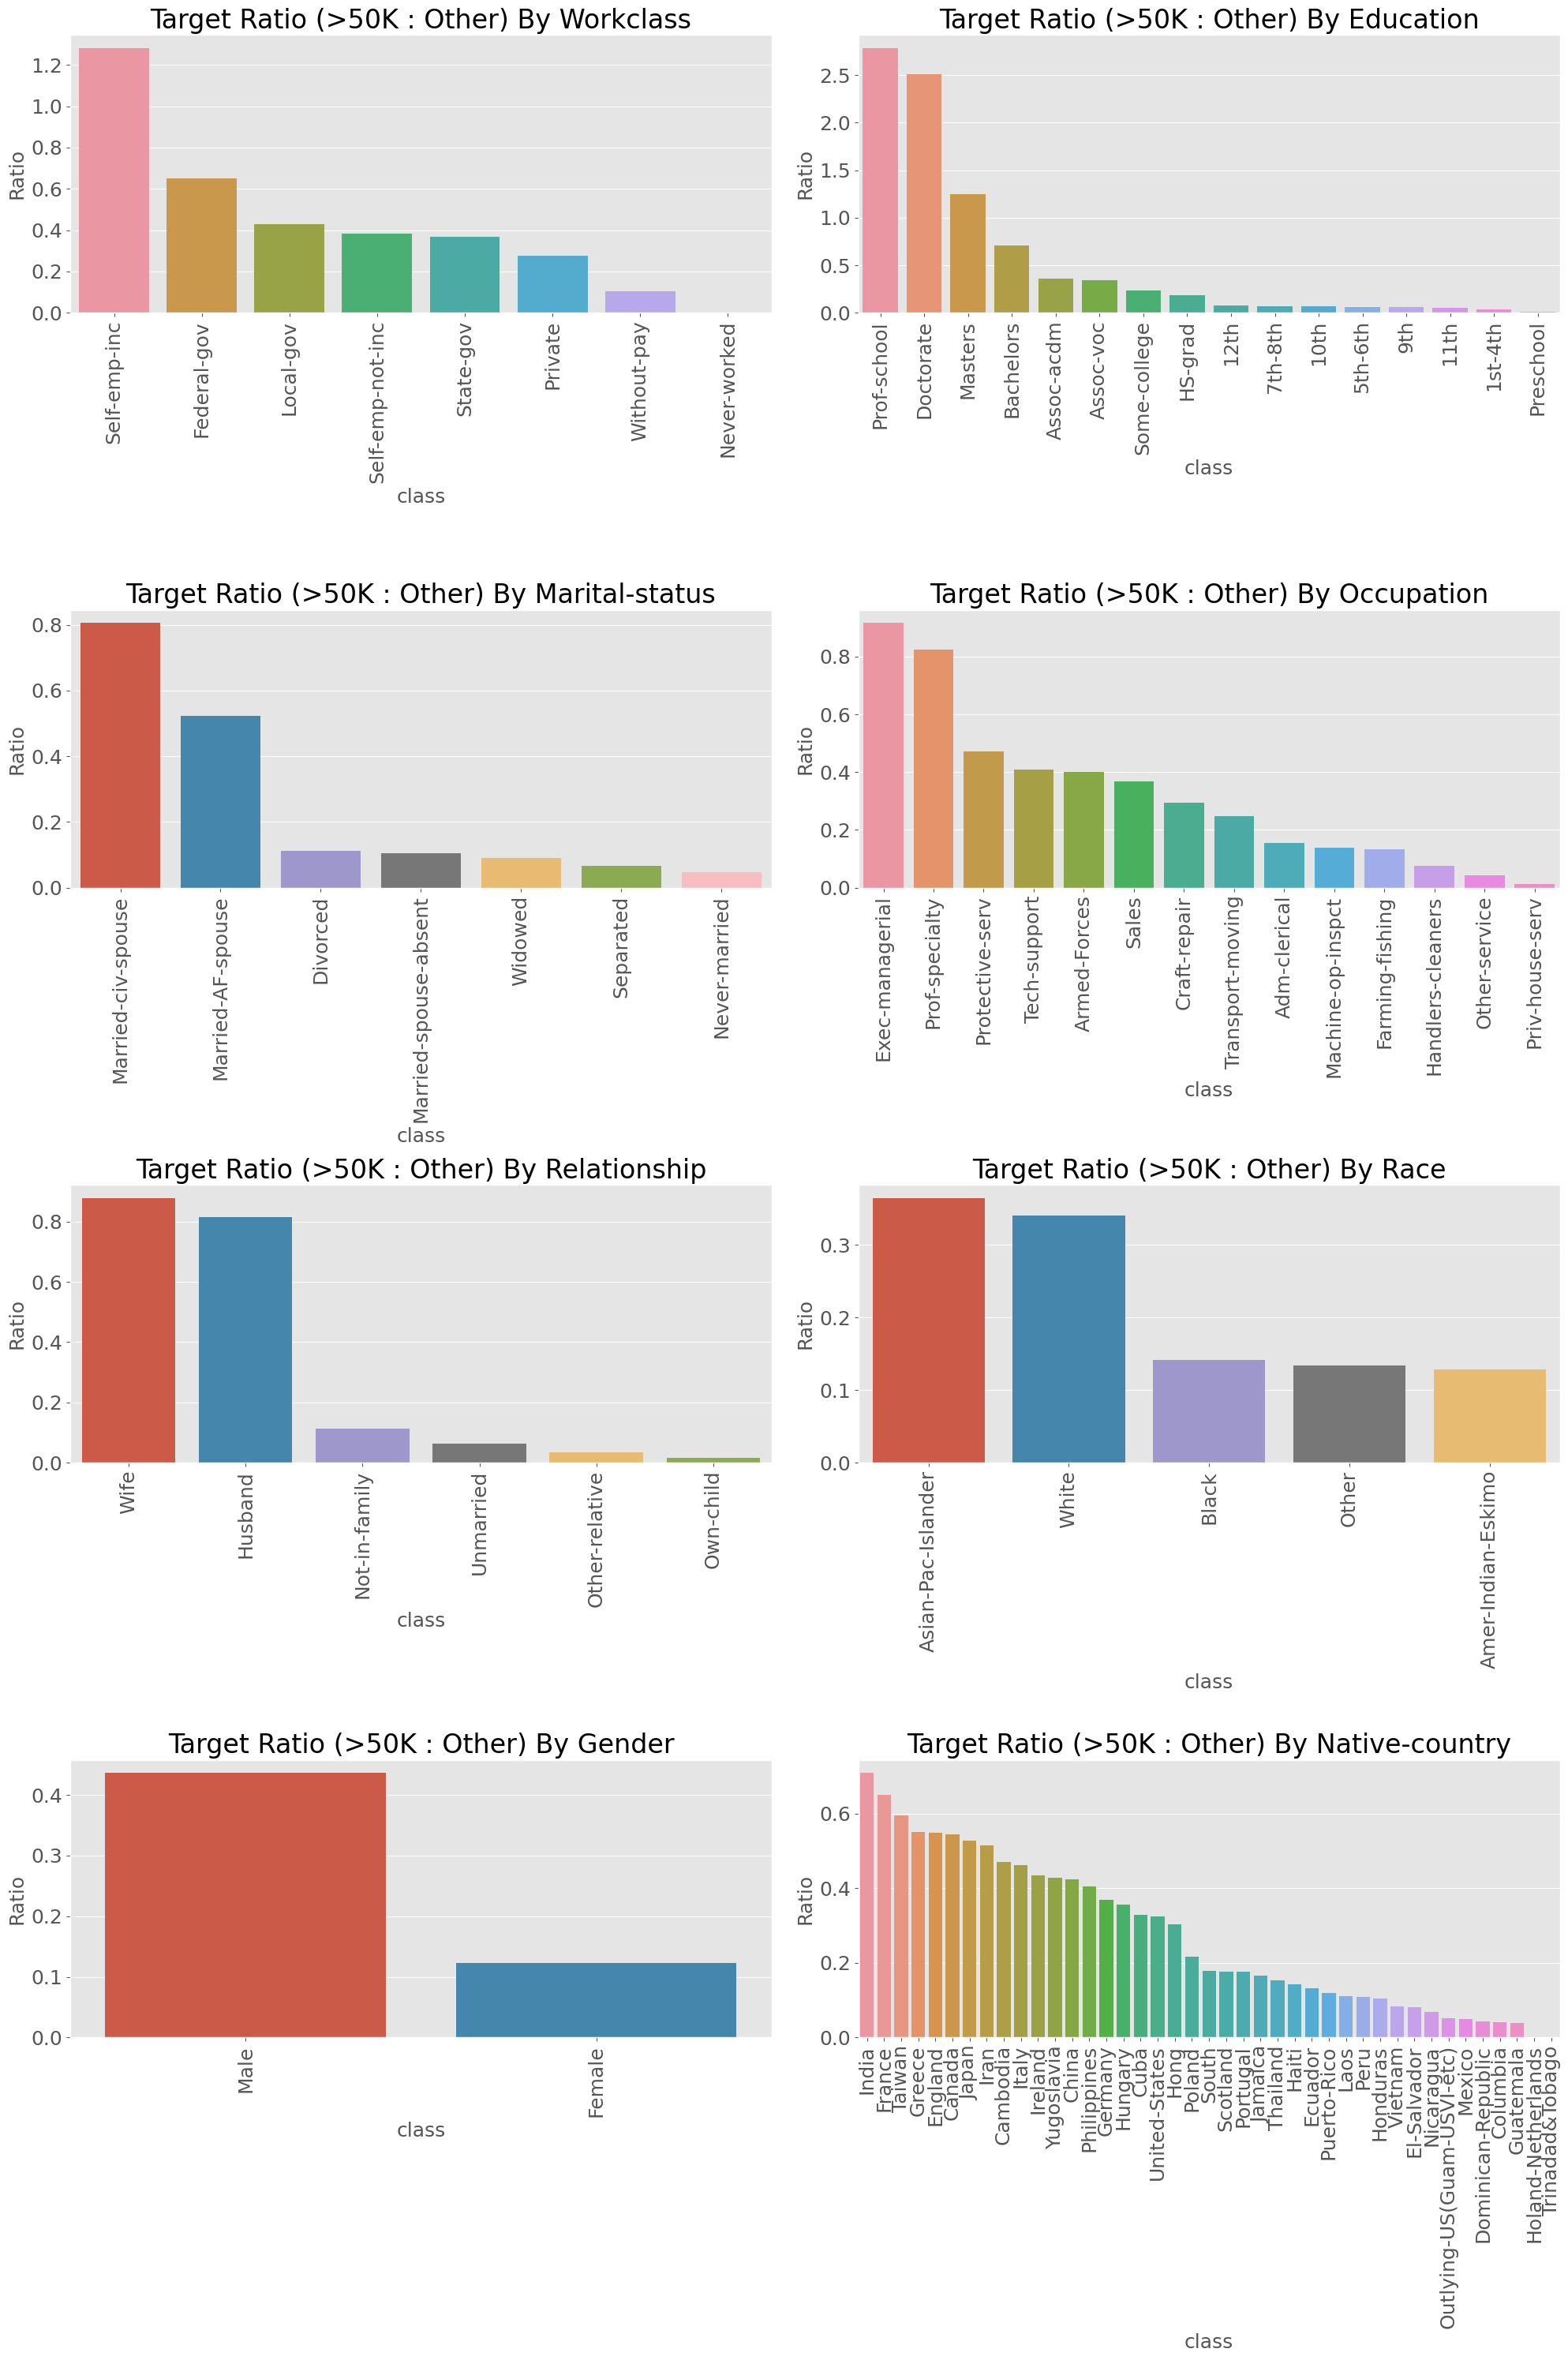

In [15]:
plt.style.use("ggplot")

cat_var = df.select_dtypes(include=["object"]).columns

# Adjust subplot dimensions based on the number of categorical variables
n_cols = 2
n_rows = len(cat_var) // n_cols + (len(cat_var) % n_cols > 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axs = axs.ravel()  # Flatten the array of axes for easier indexing

for i, col in enumerate(cat_var):
    if i >= len(axs):
        break

    # Calculate the ratio of 1 to 0 values for each category and sort by ratio
    category_grouped = df.groupby([col, 'income_>50K']).size().unstack().fillna(0)
    category_grouped['ratio'] = category_grouped[1] / (category_grouped[0] + 1)  # Avoid division by zero
    category_grouped.sort_values('ratio', ascending=False, inplace=True)  # Sort by ratio in descending order

    category_grouped.reset_index(inplace=True)

    sns.barplot(x=col, y='ratio', data=category_grouped, ax=axs[i])
    axs[i].set_title(f'Target Ratio (>50K : Other) By {col.capitalize()}', fontsize=24)  # Increase font size for title
    axs[i].set_xlabel ("class" , fontsize=18 )  # Increase font size for x-axis label
    axs[i].set_ylabel ('Ratio' , fontsize=18 )  # Increase font size for y-axis label
    axs[i].tick_params(axis='x', labelsize=18, rotation=90)  # Increase font size for x-axis tick labels
    axs[i].tick_params(axis='y', labelsize=18)  # Increase font size for y-axis tick labels

# Handle odd number of subplots: hide the last ax if unused.
if len(cat_var) % n_cols:
    axs[-1].set_visible(False)  # Hide the last ax if there's an odd number of categorical variables

plt.tight_layout()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# No surprises.

Text(0.5, 1.0, 'Target Ratio (>50K : Other) by Age Bracket')

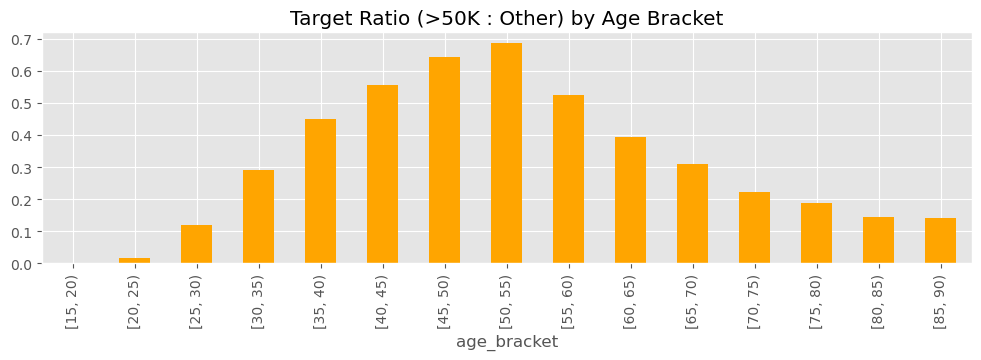

In [16]:
#################################################################################################################
#Target Variable Ratio (>50K : Other) for Binned Age Groups
#================================================================================================================
# Bin ages by every 5 years
max_age = df['age'].max()
bins = np.arange(15, max_age + 5, 5)  # Creating bins from min age to max age, every 5 years
df['age_bracket'] = pd.cut(df['age'], bins, right=False)

# Calculate counts of 'yes' and 'no' responses for each age bin
age_bin_grouped = df.groupby('age_bracket')['income_>50K'].value_counts().unstack().fillna(0)

# Compute the ratio of 'yes' to 'no' for each age bin
age_bin_grouped['ratio'] = age_bin_grouped[1] / (age_bin_grouped[0] + 1)

# Plot the ratios
plt.figure(figsize=(12, 3))
age_bin_grouped['ratio'].plot(kind='bar', color='orange')
plt.title("Target Ratio (>50K : Other) by Age Bracket")

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Target Ratio (>50K : Other) increases with age up to 55 and then decreases thereafter

Text(0.5, 1.0, 'Target Ratio (>50K : Other) by Hours-Per-Week Bracket')

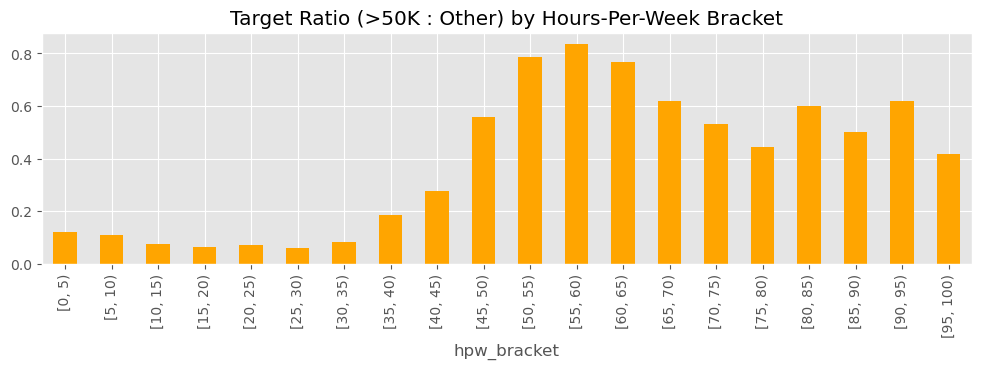

In [17]:
#################################################################################################################
#Target Variable Ratio (>50K : Other) for Binned Hours-Per-Week Groups
#================================================================================================================

# Bin ages by every 5 years
bins = np.arange(0,  df['hours-per-week'].max() + 5, 5)  # Creating bins from min to max, every 5 years
df['hpw_bracket'] = pd.cut(df['hours-per-week'], bins, right=False)

# Calculate counts of 'yes' and 'no' responses for each age bin
hpw_bin_grouped = df.groupby('hpw_bracket')['income_>50K'].value_counts().unstack().fillna(0)

# Compute the ratio of 1 to 0 for each fnlwgt bin
hpw_bin_grouped['ratio'] = hpw_bin_grouped[1] / (hpw_bin_grouped[0] + 1)

# Plot the ratios
plt.figure(figsize=(12, 3))
hpw_bin_grouped['ratio'].plot(kind='bar', color='orange')
plt.title("Target Ratio (>50K : Other) by Hours-Per-Week Bracket")

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# Target Ratio (>50K : Other) increases with hours worked up to 60 hours per week and then decreases before leveling off at 80
# hours per week and greater

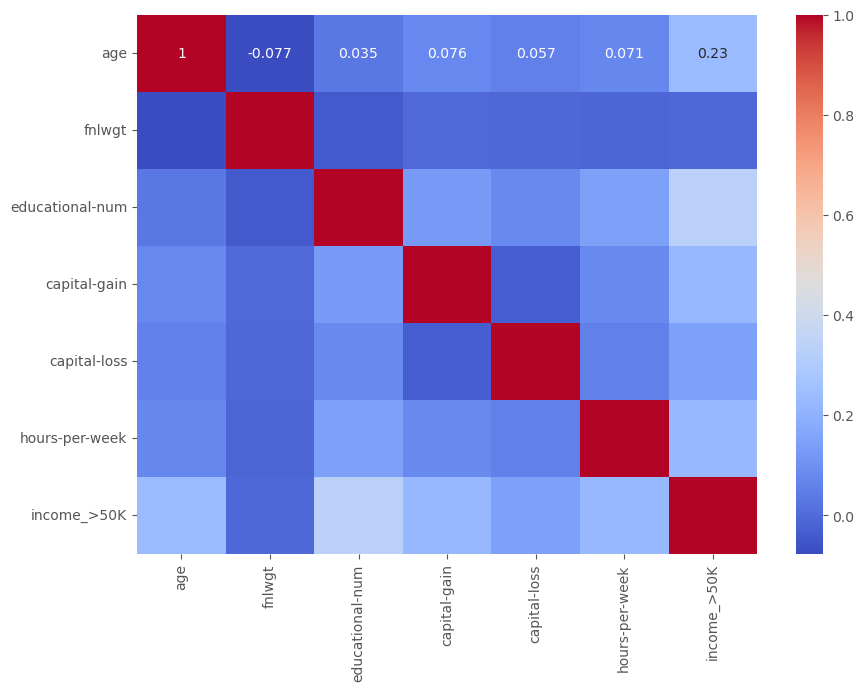

In [18]:
#################################################################################################################
#Correlation of Numeric Input Variables
#================================================================================================================

# Set the figure size for the heatmap
plt.rcParams['figure.figsize'] = [10, 7]

# Compute the correlation matrix for numeric columns only
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------
# OBSERVATIONS AFTER RUNNING
#--------------------------------------------------------------------------------------------------------------------------------
# None of the numeric input variables are well correlated, so they can be taken as independent variables.

# 3. Data Preparation

In [19]:
warnings.filterwarnings('ignore')

#################################################################################################################
# Define function for handling Outlier Vaslues in Numeric Columns Based on Quantile Analysis
#################################################################################################################

def handle_outliers(df, columns, f_handle):
    
    # Initialize lists to store the results
    lower_bounds = []
    upper_bounds = []
    outlier_cnts = []

    for i in columns:
        
        # Calculate IQR
        IQR = df[i].quantile(0.95) - df[i].quantile(0.05)
        lower_bound = np.round(df[i].quantile(0.05) - (1.5 * IQR),1)
        upper_bound = np.round(df[i].quantile(0.95) + (1.5 * IQR),1)
        
        # Calculate the number of outliers
        outliers = df[(df[i] < lower_bound) | (df[i] > upper_bound)]
        outlier_cnt = outliers.shape[0]
        
        # Print the bounds and the number of outliers
        print(f"{i:15}: LBound = {lower_bound:10}, UBound = {upper_bound:10}, Outliers = {outlier_cnt:10}")
        
        # Append the results to their respective lists
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
        outlier_cnts.append(outlier_cnt)

    print()
    if f_handle == True:
        j = 0
        for i in columns:
            df.loc[df[i] > upper_bounds[j], i] = int(upper_bounds[j])
            j = j + 1  

    # Optionally, return the lists of boundaries and counts
    return lower_bounds, upper_bounds, outlier_cnts

#################################################################################################################
# Implement Separate Modeling and Feature Importance Analyses for 1) All, 2) Native-Born, and 3) Foreign-Born
# individuals.
#################################################################################################################

#================================================================================================================
# Clean the dataframe and then separate out Native-Born from Foreign-Born individuals
#================================================================================================================

df_cleaned = df

#----------------------------------------------------------------------------------------------------------------
#Same data is already captured in the education column
#----------------------------------------------------------------------------------------------------------------

df_cleaned = df_cleaned.drop("educational-num", axis=1)
df_cleaned = df_cleaned.drop("capital-gain"   , axis=1)
df_cleaned = df_cleaned.drop("capital-loss"   , axis=1)

#----------------------------------------------------------------------------------------------------------------
#Eleminate rows from datset representing values that are under-represented in the dataset, as determined by EDA
#----------------------------------------------------------------------------------------------------------------

df_cleaned = df_cleaned[df_cleaned['age'] <= 75]
df_cleaned = df_cleaned[df_cleaned['hours-per-week'] <= 65]

#----------------------------------------------------------------------------------------------------------------
#Compute the IQR and replace outlier values with the lower and upper bounds
#----------------------------------------------------------------------------------------------------------------

columns =  ["age", "hours-per-week"]
print(f"\n{'=' * 80}\nANALYSIS\n{'=' * 80}")
print("Before Quintile Processing...")
lower_boundries, upper_boundries, outlier_counts = handle_outliers(df_cleaned, columns, True )
print("After Quintile Processing...")
lower_boundries, upper_boundries, outlier_counts = handle_outliers(df_cleaned, columns, False)

#----------------------------------------------------------------------------------------------------------------
#Compensate for skewed histograms of numeric independent variables
#----------------------------------------------------------------------------------------------------------------

df_cleaned['log-age'              ] = np.log(df_cleaned['age'           ]+1)
df_cleaned = df_cleaned.drop('age', axis=1)
df_cleaned['log-hours-per-week'   ] = np.log(df_cleaned['hours-per-week']+1)
df_cleaned = df_cleaned.drop('hours-per-week', axis=1)
df_cleaned['log-fnlwgt'           ] = np.log(df_cleaned['fnlwgt'        ]+1)
df_cleaned = df_cleaned.drop('fnlwgt', axis=1)

#----------------------------------------------------------------------------------------------------------------
#Drop dataset rows with missing values
#----------------------------------------------------------------------------------------------------------------

df_cleaned.dropna(inplace=True)

#----------------------------------------------------------------------------------------------------------------
# Aggregating specified classes into '<HS'
#----------------------------------------------------------------------------------------------------------------

classes_to_aggregate = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th']
df_cleaned['education'] = df['education'].replace(classes_to_aggregate, '<HS')

#----------------------------------------------------------------------------------------------------------------
#Understand the skewness of the target variable for binary classification
#----------------------------------------------------------------------------------------------------------------

print(df_cleaned.shape)
print(df_cleaned['income_>50K'].value_counts())

#Due to the dataset imbalance between native-born and foreign-born entries, we should look at separate models for
#each
df_all     = df_cleaned
df_native  = df_cleaned.query("`native-country` == 'United-States'") # Evaluate Native-Born Individuals on their Own
df_foreign = df_cleaned.query("`native-country` != 'United-States'") # Evaluate Foriegn-Born Individuals on their Own

df_cleaned.sample(10)


ANALYSIS
Before Quintile Processing...
age            : LBound =      -45.5, UBound =      126.5, Outliers =          0
hours-per-week : LBound =      -45.0, UBound =      123.0, Outliers =          0

After Quintile Processing...
age            : LBound =      -45.5, UBound =      126.5, Outliers =          0
hours-per-week : LBound =      -45.0, UBound =      123.0, Outliers =          0

(38524, 15)
income_>50K
0    28909
1     9615
Name: count, dtype: int64


,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income_>50K,age_bracket,hours-per-week_bracket,hpw_bracket,log-age,log-hours-per-week,log-fnlwgt
4296,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,United-States,1,"[30, 35)","[55, 60)","[55, 60)",3.555348,4.025352,11.403613
5847,Private,HS-grad,Never-married,Other-service,Not-in-family,Black,Female,United-States,0,"[35, 40)","[40, 45)","[40, 45)",3.688879,3.713572,12.548843
39279,Private,HS-grad,Divorced,Adm-clerical,Unmarried,White,Female,United-States,0,"[35, 40)","[40, 45)","[40, 45)",3.637586,3.713572,12.764802
30249,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,0,"[75, 80)","[20, 25)","[20, 25)",4.330733,3.044522,12.141134
2458,Private,Assoc-acdm,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,1,"[40, 45)","[40, 45)","[40, 45)",3.806662,3.713572,12.220335
8988,Private,Assoc-acdm,Divorced,Adm-clerical,Unmarried,White,Female,United-States,0,"[40, 45)","[40, 45)","[40, 45)",3.761200,3.713572,10.941713
37555,Private,HS-grad,Never-married,Handlers-cleaners,Not-in-family,Black,Male,United-States,0,"[35, 40)","[40, 45)","[40, 45)",3.663562,3.713572,12.075064
18057,Private,Some-college,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,United-States,1,"[40, 45)","[50, 55)","[50, 55)",3.761200,3.931826,10.736831
15153,Private,Some-college,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,1,"[45, 50)","[40, 45)","[40, 45)",3.891820,3.713572,11.789246
36476,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,1,"[30, 35)","[40, 45)","[40, 45)",3.555348,3.713572,12.100034


# 4. Predictive Modeling / 5. Feature Importance

In [20]:
#Implement predictive modeling and feature importance analysis. This routine scales numeric columns and 
#encodes categorical columns via a piepline. The dataset is then split into training and test sets. Oversampling
#is then applied to balance out the classes in the target variable, if desired (only when f_resample = True)
#is set in the run_models function. Finally, the code implements five different classifiers using GridSearchCV
#to determine the best Hyper-Parameters for each and reports the Feature Importances for each classifier
#based on the best parameters found for that classifier.

##############################################################################################################
#Function to Retain Feature Names with OneHotEncoding
##############################################################################################################

def get_feature_names(column_transformer):
    
    output_features = []

    for transformer_info in column_transformer.transformers_:
        name, transformer, original_feature_names = transformer_info
        if name == 'remainder':
            if column_transformer.remainder == 'passthrough':
                remainder_cols = column_transformer.feature_names_in_  # If remainder='passthrough', include original column names
                output_features.extend([remainder_cols[i] for i in range(len(remainder_cols)) if i not in column_transformer._transformer_to_input_indices(name)])
            continue
        if hasattr(transformer, 'steps'):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer
        if hasattr(last_step, 'get_feature_names_out'):
            feature_names = last_step.get_feature_names_out(original_feature_names)  # Use the transformer's 'get_feature_names_out' method if available
        else:
            feature_names = original_feature_names                                   # Otherwise, use the original feature names directly
        output_features.extend(feature_names)
    
    return output_features

##############################################################################################################
#Function to Aggregate Feature Importances
##############################################################################################################

def aggregate_feature_importances(importances, feature_names, s):
    # Aggregate importances for original features
    aggregated_importances = {}
    for importance, feature_name in zip(importances, feature_names):
        original_feature = feature_name.split(s)[0]  # Splitting based on your OneHotEncoding naming convention
        if original_feature in aggregated_importances:
            aggregated_importances[original_feature] += np.abs(importance)  # Summing absolute importance for aggregated features
        else:
            aggregated_importances[original_feature] = np.abs(importance)
    return aggregated_importances

##############################################################################################################
#Function to Prepare the Data
##############################################################################################################

def prepare_data(df_in, target_column, f_resample=False):
    
    #=========================================================================================================
    # Split Target Variable from Independent Variables
    #=========================================================================================================
    
    X = df_in.drop(target_column, axis=1)
    y = df_in[target_column]
    
    #=========================================================================================================
    # Preprocessing pipelines for both numeric and categorical data
    #=========================================================================================================

    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])
    preprocessor = ColumnTransformer([
        ('num', num_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', cat_transformer, X.select_dtypes(include=['object']).columns)])
    
    X_encoded = preprocessor.fit_transform(X)
    feature_names = get_feature_names(preprocessor)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
  
    print("Before resampling:\n", y_train.value_counts())

    if f_resample == True:
        smote= SMOTETomek(sampling_strategy=0.75)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    print("After resampling :\n", y_train.value_counts())

    return X_train, X_test, y_train, y_test, feature_names, preprocessor

##############################################################################################################
#Function to Evaluate and Print the confusion Matrix and Related Metrics
##############################################################################################################

def evaluate_predictions(y_true, y_pred, model_name, threshold, type):

    print("-" * 135)
    print(f"{type} Threshold: {threshold:.2f}")
    
    # Generating the Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{cm}")
    
    # Calculating Metrics
    accuracy  = accuracy_score (y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score   (y_true, y_pred)
    f1        = f1_score       (y_true, y_pred)
    
    # Output Reults
    print(f"Metrics:")
    print(f"Accuracy : {accuracy:.2f}" )
    print(f"Precision: {precision:.2f}")
    print(f"Recall   : {recall:.2f}"   )
    print(f"F1 Score : {f1:.2f}"       )

##############################################################################################################
# Neural Network Model Function
##############################################################################################################

def create_model(input_dim, layers=[64, 64], activation='relu', optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=input_dim, activation=activation))
    for units in layers[1:]:
        model.add(Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Change loss for multi-class
    return model
    
##############################################################################################################
#Function to Implement Encoding, Model Fit, and Provide Feature Importances
##############################################################################################################

def run_models(df_in, target_col, f_resample=False):

#   Provide the dataframe to be used for the analysis and set f_resample to True if oversampling is desired to
#   balance out the classes in the target variable. IMPORTANT: Oversampling is applied only to training data-
#   sets, NEVER to test data sets!

    X_train, X_test, y_train, y_test, feature_names, preprocessor = prepare_data(df_in, target_col, f_resample)

    #=========================================================================================================
    # Hyper-Parameters for GridSearch
    #=========================================================================================================

    classifiers = {'LogisticRegression': { 'model' : LogisticRegression(solver='liblinear'),
                                           'params': {'C'                 : 10.0 ** np.arange(-2, 3)  ,
                                                      'penalty'           : ['l1', 'l2'              ]}}
                   ,
                   'KNeighbors'        : { 'model' : KNeighborsClassifier(),
                                           'params': {'n_neighbors'       : [3, 5, 7, 10             ],
                                                      'metric'            : ['euclidean', 'manhattan'],
                                                      'weights'           : ['uniform'  , 'distance' ]}}
                   ,
                   'DecisionTree'      : { 'model' : DecisionTreeClassifier(),
                                           'params': {'max_depth'         : [None, 5, 10, 15, 20, 30 ],
                                                      'min_samples_leaf'  : [1, 2, 4                 ],
                                                      'min_samples_split' : [2, 5, 10                ]}}
                   ,
                   'RandomForest'      : { 'model' : RandomForestClassifier(),
                                           'params': {'n_estimators'      : [10, 50, 100             ],
                                                      'max_depth'         : [None, 5, 10, 15, 20     ],
                                                      'min_samples_leaf'  : [1, 2, 4                 ],
                                                      'min_samples_split' : [2, 5, 10                ]}}
                   ,
                   'NeuralNetwork'     : { 'model' : KerasClassifier(build_fn=create_model, input_dim=X_train.shape[1], layers=[0, 0], activation='relu', optimizer='adam', dropout_rate=0.0),
                                           'params': {'epochs'            : [10, 20                  ],
                                                      'batch_size'        : [16, 32                  ],
                                                      'layers'            : [[64, 64], [64, 64, 32]  ],
                                                      'optimizer'         : ['adam', 'rmsprop'       ],
                                                      'dropout_rate'      : [0.0, 0.2                ]}}
#                   ,
#                   'SVM'               : { 'model' : SVC(),
#                                           'params': {'C'                 : [0.1, 1, 10, 100         ],
#                                                      'kernel'            : ['linear', 'rbf'         ],
#                                                      'gamma'             : ['scale', 'auto'         ]}}
                  }

    #=========================================================================================================
    # Loop through classifiers to Implement Gridsearch and Feature Importance ANalysis for Each
    #=========================================================================================================

    fpr_list           = []
    tpr_list           = []
    auc_list           = []
    model_names        = []
    optimal_thresholds = []
    
    for name, info in classifiers.items():
        
        print(f"\n{'#' * 135}\nTraining {name}\n{'#' * 135}")

        #-----------------------------------------------------------------------------------------------------
        # Implement GridSearchCV
        #-----------------------------------------------------------------------------------------------------

        start_time = time.time()  # Start timing
        gridsearch = GridSearchCV(info['model'], info['params'], cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
        gridsearch.fit(X_train, y_train)
        duration = time.time() - start_time
    
        #-----------------------------------------------------------------------------------------------------
        # Provide Evaluation of Performance for Best Model
        #-----------------------------------------------------------------------------------------------------

        y_pred = gridsearch.predict(X_test)       # Make predictions on the test set

        print(f'Classification Report for {name} using best parameters::\n{classification_report(y_test, y_pred)}')
        print("-" * 135)
        # Display the best parameters and score for each classifier
        print(f"Best parameters for {name}: {gridsearch.best_params_}")
        print(f"Best Training Score for {name}: {gridsearch.best_score_}")
        print(f"Training duration: {duration:.2f} seconds")
        print()

        #-----------------------------------------------------------------------------------------------------
        # Determine ROC Curves
        #-----------------------------------------------------------------------------------------------------

        if hasattr(gridsearch.best_estimator_, "predict_proba"):
            y_score = gridsearch.predict_proba(X_test)[:, 1]
        else:
            # For models that do not have predict_proba but have a decision function
            y_score = gridsearch.decision_function(X_test)
            
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Evaluate Standard threshold
        y_pred_standard = (y_score >= 0.5).astype(int)
        evaluate_predictions(y_test, y_pred_standard, name, 0.5, "Default")
        
        # Find and Evaluate Optimal Threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)
        y_pred_optimal = (y_score >= optimal_threshold).astype(int)
        evaluate_predictions(y_test, y_pred_optimal, name, optimal_threshold, "Optimal")
       
        # Append ROC data to lists
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)
        model_names.append(name)
    
        #-----------------------------------------------------------------------------------------------------
        # Plot Feature Importances i
        #-----------------------------------------------------------------------------------------------------

        best_model = gridsearch.best_estimator_
        feature_names = get_feature_names(preprocessor)  # Extract feature names
    
        if hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_'):
            importances = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else best_model.coef_[0]
            aggregated_importances = aggregate_feature_importances(importances, feature_names,'_')
        
            # Sorting features by importance
            sorted_features = sorted(aggregated_importances.items(), key=lambda item: item[1], reverse=True)
            sorted_feature_names, sorted_importances = zip(*sorted_features)
        
            # Plotting
            plt.figure(figsize=(10, 3))
            plt.title(f'Aggregated Feature Importances for {name}')
            plt.bar(range(len(sorted_feature_names)), sorted_importances, align='center')
            plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

    # Plot aggregated ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(len(model_names)):
        plt.plot(fpr_list[i], tpr_list[i], lw=2, label=f'{model_names[i]} (area = {auc_list[i]:.2f})')
        optimal_idx = np.argmax(tpr_list[i] - fpr_list[i])
        plt.plot(fpr_list[i][optimal_idx], tpr_list[i][optimal_idx], 'o', markersize=10,
                 label=f"Optimal threshold for {model_names[i]}: {optimal_thresholds[i]:.2f}", fillstyle="none", c='k', mew=2)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

Before resampling:
 income_>50K
0    2193
1     498
Name: count, dtype: int64
After resampling :
 income_>50K
0    2181
1    1632
Name: count, dtype: int64

#######################################################################################################################################
Training LogisticRegression
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogisticRegression using best parameters::
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       539
           1       0.57      0.77      0.66       134

    accuracy                           0.84       673
   macro avg       0.75      0.81      0.78       673
weighted avg       0.86      0.84      0.85       673

--------------------------------------------------------------------------------------

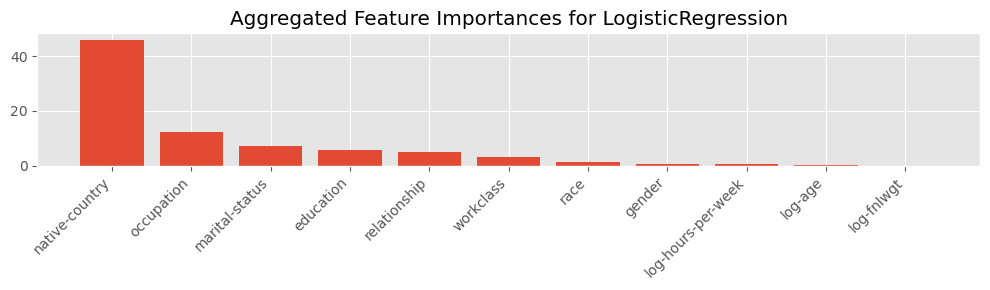


#######################################################################################################################################
Training KNeighbors
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNeighbors using best parameters::
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       539
           1       0.49      0.75      0.59       134

    accuracy                           0.79       673
   macro avg       0.71      0.78      0.73       673
weighted avg       0.84      0.79      0.81       673

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNeighbors: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Training Score for K

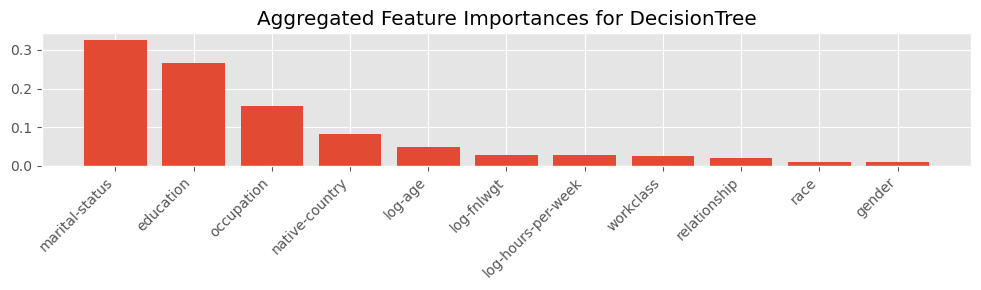


#######################################################################################################################################
Training RandomForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RandomForest using best parameters::
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       539
           1       0.68      0.63      0.65       134

    accuracy                           0.87       673
   macro avg       0.80      0.78      0.79       673
weighted avg       0.86      0.87      0.87       673

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators':

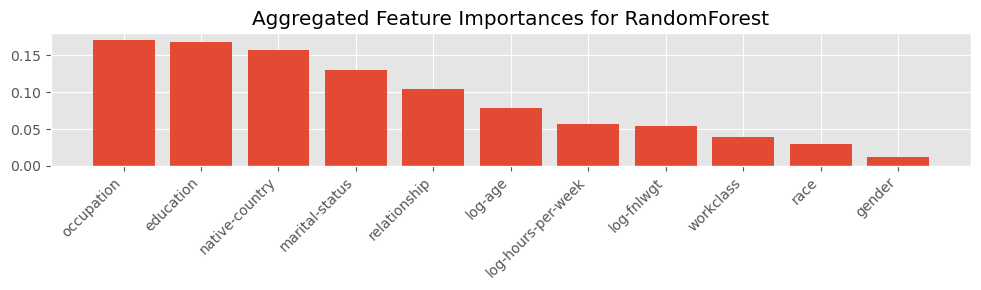


#######################################################################################################################################
Training NeuralNetwork
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/20
120/120 [==============================] - 1s 897us/step - loss: 0.4998 - accuracy: 0.7640
Epoch 2/20
120/120 [==============================] - 0s 778us/step - loss: 0.3603 - accuracy: 0.8497
Epoch 3/20
120/120 [==============================] - 0s 878us/step - loss: 0.3239 - accuracy: 0.8678
Epoch 4/20
120/120 [==============================] - 0s 828us/step - loss: 0.2896 - accuracy: 0.8788
Epoch 5/20
120/120 [==============================] - 0s 790us/step - loss: 0.2636 - accuracy: 0.8954
Epoch 6/20
120/120 [==============================] - 0s 790us/step - loss: 0.2399 - accuracy: 0.9069
Epoch 7/20
120/120 [==========

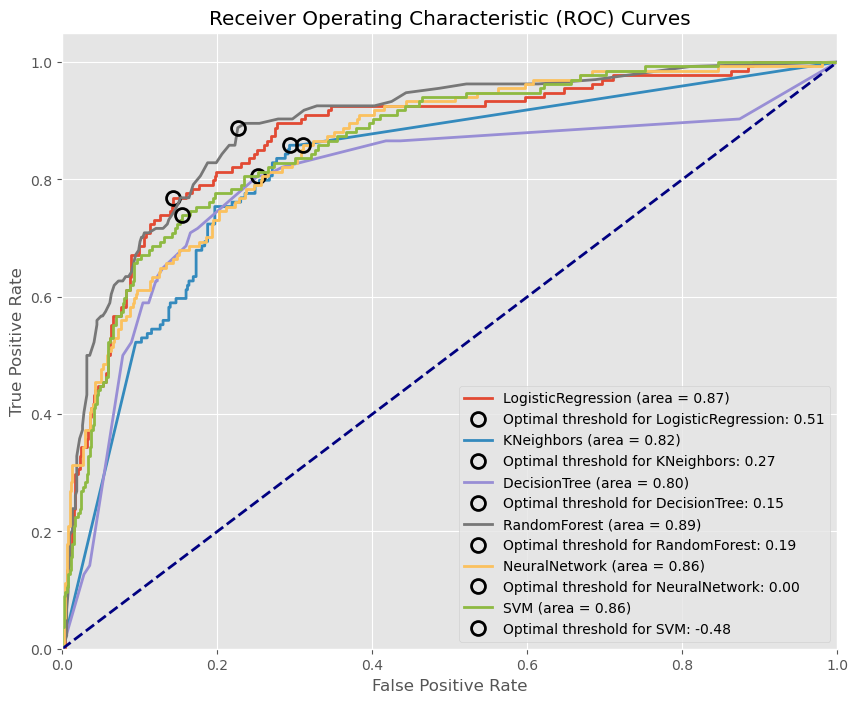

In [42]:
#RUN ANALSYSIS 1: FOREIGN_BORN INDIVIDUALS
run_models(df_foreign, 'income_>50K', True)

Before resampling:
 income_>50K
0    20914
1     7214
Name: count, dtype: int64
After resampling :
 income_>50K
0    19952
1    14723
Name: count, dtype: int64

#######################################################################################################################################
Training LogisticRegression
#######################################################################################################################################
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification Report for LogisticRegression using best parameters::
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      5263
           1       0.59      0.77      0.67      1769

    accuracy                           0.81      7032
   macro avg       0.75      0.79      0.76      7032
weighted avg       0.83      0.81      0.81      7032

----------------------------------------------------------------------------------

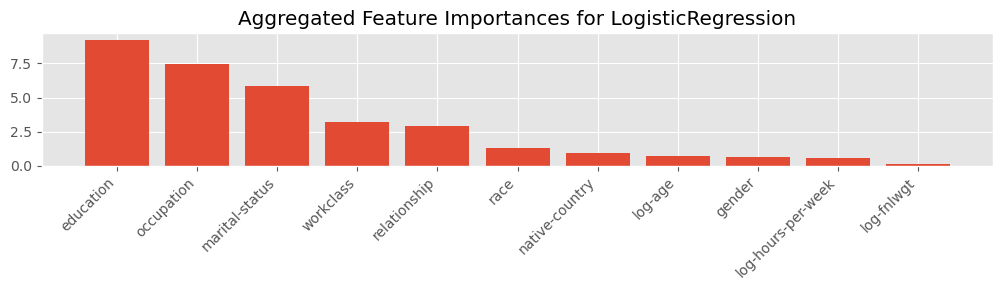


#######################################################################################################################################
Training KNeighbors
#######################################################################################################################################
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report for KNeighbors using best parameters::
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      5263
           1       0.54      0.69      0.61      1769

    accuracy                           0.78      7032
   macro avg       0.71      0.75      0.72      7032
weighted avg       0.80      0.78      0.78      7032

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for KNeighbors: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Training Score for K

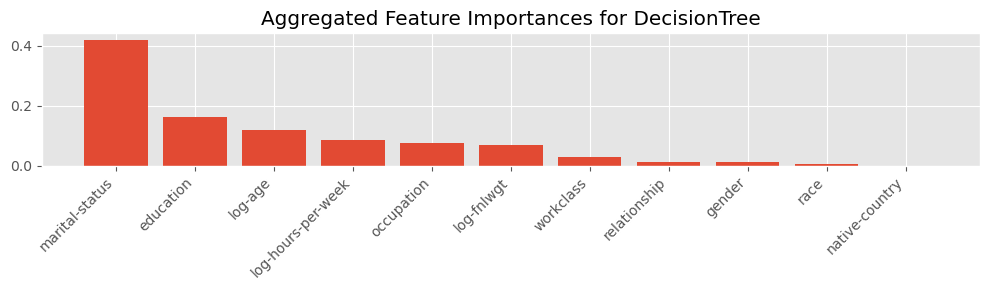


#######################################################################################################################################
Training RandomForest
#######################################################################################################################################
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Classification Report for RandomForest using best parameters::
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5263
           1       0.63      0.65      0.64      1769

    accuracy                           0.82      7032
   macro avg       0.76      0.76      0.76      7032
weighted avg       0.82      0.82      0.82      7032

---------------------------------------------------------------------------------------------------------------------------------------
Best parameters for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators':

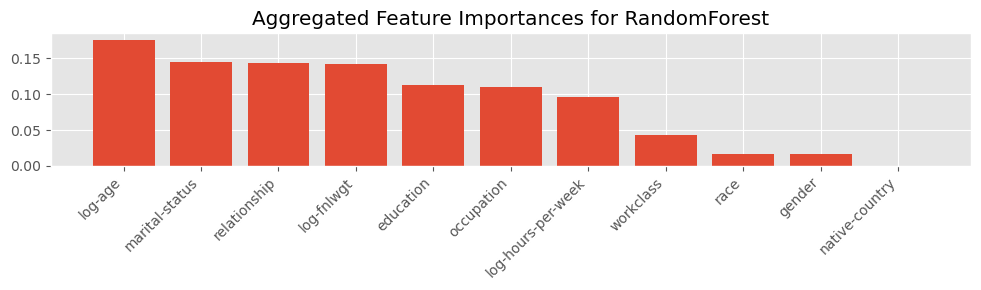


#######################################################################################################################################
Training NeuralNetwork
#######################################################################################################################################
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Epoch 1/20
2168/2168 [==============================] - 2s 630us/step - loss: 0.3813 - accuracy: 0.8229
Epoch 2/20
2168/2168 [==============================] - 1s 618us/step - loss: 0.3620 - accuracy: 0.8364
Epoch 3/20
2168/2168 [==============================] - 1s 614us/step - loss: 0.3525 - accuracy: 0.8399
Epoch 4/20
2168/2168 [==============================] - 1s 611us/step - loss: 0.3450 - accuracy: 0.8433
Epoch 5/20
2168/2168 [==============================] - 1s 626us/step - loss: 0.3376 - accuracy: 0.8467
Epoch 6/20
2168/2168 [==============================] - 1s 627us/step - loss: 0.3294 - accuracy: 0.8521
Epoch 7/20
2168/21

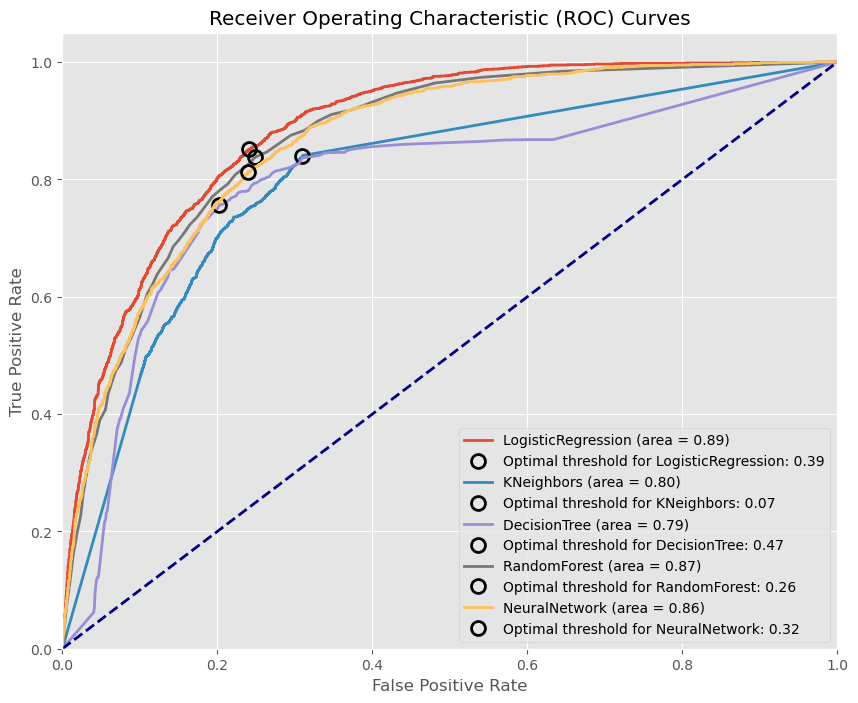

In [21]:
#RUN ANALSYSIS 1: NATIVE-BORN INDIVIDUALS
run_models(df_native, 'income_>50K', True)